### Import packages

In [1]:
# Computing
import numpy as np
from numba import jit
from pylab import meshgrid
import decimal

# Profiling
import time
import cProfile
import pstats
import io

# Plotting Utilities
import matplotlib.pyplot as plt
from IPython import display
import ipywidgets as widgets
from ipywidgets import interactive
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## General Functions

### SSP-RK methods

For time integratration, we use explicit, strong-stability-preseriving Runge-Kutta (SSP-RK) methods to advance the solution from $t^{n}$ to $t^{n+1}$. Let $u^{n} = u(x,t^{n})$ denote the semi-discrete numerical solution at time $t^{n}$. The SSP-RK methods involve convex combinations of forward euler steps, with high-order accuracy being obtained by choosing constants so that the error terms in the Taylor expansion disappear. In practice, we will couple the $k$-stage SSP-RK method with the $k$-th partial sum of the resolvent expansions to maintain consistency.

The time integration schemes we will be considering for the HJ equation include the forward Euler scheme

\begin{equation}
    u^{n+1} = u^{n} - \Delta t \hat{H} \left( u_{x}^{-}, u_{x}^{+}, t^{n} \right),
\end{equation}

the two-stage SSP-RK scheme

\begin{align}
    u^{(1)} &= u^{n} - \Delta t \hat{H} \left( u_{x}^{n,-}, u_{x}^{n,+}, t^{n} \right) \\
    u^{n+1} &= \frac{1}{2} u^{n} + \frac{1}{2} \left( u^{(1)} - \Delta t \hat{H} \left( u_{x}^{(1),-}, u_{x}^{(1),+}, t^{n} + \Delta t \right) \right)
\end{align}

and the popular three-stage SSP-RK scheme

\begin{align}
    u^{(1)} &= u^{n} - \Delta t \hat{H} \left( u_{x}^{n,-}, u_{x}^{n,+}, t^{n} \right) \\
    u^{(2)} &= \frac{3}{4} u^{n} + \frac{1}{4} \left( u^{(1)} - \Delta t \hat{H} \left( u_{x}^{(1),-}, u_{x}^{(1),+}, t^{n} + \Delta t \right) \right) \\
    u^{n+1} &= \frac{1}{3} u^{n} + \frac{2}{3} \left( u^{(2)} - \Delta t \hat{H} \left( u_{x}^{(2),-}, u_{x}^{(2),+}, t^{n} + 0.5 \Delta t \right) \right).
\end{align}

$dy/dt = f(y,t)$

In [2]:
def RK1(io, u0, u, dt, rhs): 
    # Forward Euler update
    u += dt*rhs

    return u

def RK2(io, u0, u, dt, rhs): #when you input your rhs, make sure rhs(t?) is at the right time level. 
    if (io==0):
        u = u0 + dt*rhs
    else:
        u = 0.5*u0 + 0.5*(u + dt*rhs)

    return u

def RK3(io, u0, u, dt, rhs):
    if (io==0):
        u = u0 + dt*rhs
    elif (io==1):
        u = 3/4*u0 + 1/4*(u + dt*rhs)
    else:
        u = 1/3*u0 + 2/3*(u + dt*rhs)

    return u

### Setting the Time Step - HJ

In 1-D, we select the time step at each interation using

\begin{equation*}
    \Delta t = \text{CFL} \frac{ \Delta x }{ \alpha },
\end{equation*}

where $\alpha$ is the maximum wave propogation speed and is given by $ \alpha = \max_{u} \lvert H'(u) \rvert. $
Note: We need to compute $\alpha$ at each time step to get the new value for $\Delta t$. The expression for $ H'(u)$ is determined analytically. We compute the time step size using the function below:

In [3]:
def set_dt_HJ_1D(t,t_final,CFL,dx,alpha):
    '''
    This is the function used to compute the time step size dt.
    
    Input:
    =================================================================
    t: Current time for the integrator.
    t_final: Final time for the integrator.
    CFL: Courant number. 
    dx: Spatial step size.
    alpha: Max wave propagation speed.
    
    Output:
    =================================================================
    dt: Time step size for the next iteration. 
    '''
    dt = CFL*dx / alpha
    
    # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t
        
    return dt

In [4]:
def set_dt_HJ_2D(t,t_final,CFL,dx,dy,alphax,alphay):
    '''
    This is the function used to compute the time step size dt.
    
    Input:
    =================================================================
    t: Current time for the integrator.
    t_final: Final time for the integrator.
    CFL: Courant number. 
    dx: Spatial step size.
    alpha: Max wave propagation speed.
    
    Output:
    =================================================================
    dt: Time step size for the next iteration. 
    '''
    dt = CFL / (alphax/dx + alphay/dy)
    
    # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t
        
    return dt

### Setting the time step - AD

In 1-D, we select the time step at each interation using

\begin{equation*}
    \Delta t = \text{CFL} \frac{ \Delta x }{ q + c }.
\end{equation*}

In [5]:
def set_dt_AD_1D(t,t_final,CFL,dx,cmax,qmax):
    '''
    This is the function used to compute the time step size dt.

    Input:
    =================================================================
    t: Current time for the integrator.
    t_final: Final time for the integrator.
    CFL: Courant number.
    dx: Spatial step size.
    cmax: Max wave propogation speed depend on f(u).
    qmax: Max wave propogation speed depend on g(u).

    Output:
    =================================================================
    dt: Time step size for the next iteration.
    '''
    dt = CFL * dx / ( cmax + qmax )

    # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t

    return dt

## Spatial discretization

In [6]:
# @jit
def WENO_L(v,alpha,dx,bdy_ext):
    '''
    Compute the fifth order WENO-Z quadrature approximation to the
    left convolution integral using a six point global stencil.

    Input:
    =================================================================
    v: A 1-D array for the solution at the time step t_n.
    alpha: Parameter specified by MOLT discretization.
    dx: Grid spacing.
    bdy_ext: A function for boundary extension.

    Output:
    =================================================================
    J_L: A 1-D array for the reconstructed local integrals to the left.
    xi_L: 1-D array of parameters required for the left-based filter.
    '''
    # We need gamma*dx here, so we adjust the value of gamma
    gamma = alpha*dx

    # Set the WENO epsilon parameter
    epsilon = 1e-6

    # Get the total number of elements in v
    len_v = v.shape[0]

    # Create the arrays to store the local integrals and the filter data
    J_L = np.zeros((len_v))
    xi_L = np.zeros((len_v))

        
    # #------------------------------------------------------------------------------------------------------------------
    # # Compute the "ENO" weights for the quadrature using the precomputed expressions for the left approximation
    # # When the mesh is small, due to the machine precision, the coefficients are not accurate enough to give the desired 
    # # convergence order. We need to use "decimal". Email us for more details how to do that. 
    # #------------------------------------------------------------------------------------------------------------------
    cl_11 = ( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    cl_12 = -( 6 - 8*gamma + 3*gamma**2 - ( 6 - 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    cl_13 = ( 6 - 10*gamma + 6*gamma**2 - ( 6 - 4*gamma - gamma**2 + 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    cl_14 = -( 6 - 12*gamma + 11*gamma**2 - 6*gamma**3 - ( 6 - 6*gamma + 2*gamma**2)*np.exp(-gamma) )/(6*gamma**3)
    
    cl_21 = ( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    cl_22 = -( 6 - 2*gamma - 2*gamma**2 - ( 6 + 4*gamma - gamma**2 - 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    cl_23 = ( 6 - 4*gamma - gamma**2 + 2*gamma**3 - ( 6 + 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    cl_24 = -( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    
    cl_31 = ( 6 + 6*gamma +2*gamma**2 - ( 6 + 12*gamma + 11*gamma**2 + 6*gamma**3 )*np.exp(-gamma) )/(6*gamma**3)
    cl_32 = -( 6 + 4*gamma - gamma**2 - 2*gamma**3 - ( 6 + 10*gamma + 6*gamma**2 )*np.exp(-gamma) )/(2*gamma**3 )
    cl_33 = ( 6 + 2*gamma - 2*gamma**2 - ( 6 + 8*gamma + 3*gamma**2 )*np.exp(-gamma) )/(2*gamma**3 )
    cl_34 = -( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    
    #------------------------------------------------------------------------------------------------------------------
    # Compute the linear weights
    #------------------------------------------------------------------------------------------------------------------
    d1 = ( 60 - 15*gamma**2 + 2*gamma**4 - ( 60 + 60*gamma + 15*gamma**2 - 5*gamma**3 - 3*gamma**4)*np.exp(-gamma) )
    d1 = d1/(10*(gamma**2)*( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) ) )
    
    d3 = ( 60 - 60*gamma + 15*gamma**2 + 5*gamma**3 - 3*gamma**4 - ( 60 - 15*gamma**2 + 2*gamma**4)*np.exp(-gamma) )
    d3 = d3/(10*(gamma**2)*( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) ) )

    d2 = 1 - d1 - d3
   

    # Check to make sure the left based linear weights are non-negative
    if (d1 < 0) or (d2 < 0) or (d3 < 0):
        print("Error: Negative linear weight(s)")
       

    # Boundary Extension
    bn = 2
    v2 = bdy_ext(v, bn)

    #------------------------------------------------------------------------------------------------------------------
    # Compute the local integrals J_{i}^{L} on x_{i-1} to x_{i}, i = 1,...,N+1
    #------------------------------------------------------------------------------------------------------------------
    for i in range(1+bn, len_v+bn):

        # Compute the smoothness indicators beta_i
        beta1 = (781)*(-v2[i-3] + 3*v2[i-2] - 3*v2[i-1] +   v2[i])**2 + \
                (195)*( v2[i-3] - 5*v2[i-2] + 7*v2[i-1] - 3*v2[i])**2 + \
                (720)*(                       1*v2[i-1] - 1*v2[i])**2

        beta2 = (781)*(-v2[i-2] + 3*v2[i-1] - 3*v2[i] + v2[i+1])**2 + \
                (195)*( v2[i-2] -   v2[i-1] -   v2[i] + v2[i+1])**2 + \
                (720)*(           1*v2[i-1] - 1*v2[i]          )**2

        beta3 = (781)*(-  v2[i-1] + 3*v2[i] - 3*v2[i+1] + v2[i+2])**2 + \
                (195)*(-3*v2[i-1] + 7*v2[i] - 5*v2[i+1] + v2[i+2])**2 + \
                (720)*( 1*v2[i-1] - 1*v2[i]                      )**2

        # Compute the absolute difference between beta1 and beta3
        tau = np.abs(beta1 - beta3)

        # Compute the nonlinear filter
        beta_max = 1 + ( tau/( epsilon + min(beta1,beta3) ) )
        beta_min = 1 + ( tau/( epsilon + max(beta1,beta3) ) )

        xi_L[i-bn] = beta_min/beta_max #from 1, 2, ..., N+1 (missing 0th point)

        # Transform the linear weights to nonlinear weights
        omega1 = d1 / (epsilon + beta1)**2
        omega2 = d2 / (epsilon + beta2)**2
        omega3 = d3 / (epsilon + beta3)**2

        # Normalize the weights so they sum to unity
        omega_sum = omega1 + omega2 + omega3
        omega1 = omega1/omega_sum
        omega3 = omega3/omega_sum
        omega2 = 1 - omega1 - omega3

        # Polynomial interpolants on the substencils
        p1 = cl_11*v2[i-3] + cl_12*v2[i-2] + cl_13*v2[i-1] + cl_14*v2[i  ]
        p2 = cl_21*v2[i-2] + cl_22*v2[i-1] + cl_23*v2[i  ] + cl_24*v2[i+1]
        p3 = cl_31*v2[i-1] + cl_32*v2[i  ] + cl_33*v2[i+1] + cl_34*v2[i+2]

        # # Compute the integral using the nonlinear weights and the local polynomials
        # J_L[i-bn] = omega1*p1 + omega2*p2 + omega3*p3
        # J_L[i-bn] = d1*p1 + d2*p2 + d3*p3
        J_L[i-bn] = p1

    return J_L, xi_L #nonlinear filter parameters are needed

In [7]:
# @jit
def WENO_R(v,alpha,dx,bdy_ext):
    '''
    Compute the fifth order WENO-Z quadrature approximation to the
    right convolution integral using a six point global stencil.

    Input:
    =================================================================
    v: A 1-D array for the solution at the time step t_n.
    alpha: Parameter specified by MOLT discretization.
    dx: Grid spacing.
    bdy_ext: A function for boundary extension.

    Output:
    =================================================================
    J_R: A 1-D array for the reconstructed local integrals to the right.
    xi_R: 1-D array of parameters required for the right-based filter.
    '''
    # We need gamma*dx here, so we adjust the value of gamma
    gamma = alpha*dx
    
    

    # Set the WENO epsilon parameter
#     epsilon = decimal.Decimal('0.0000001')
    epsilon = 1e-6

    # Get the total number of elements in v
    len_v = v.shape[0]

    # Create the arrays to store the local integrals and the filter data
    J_R = np.zeros((len_v))
    xi_R = np.zeros((len_v))
    

# #     #------------------------------------------------------------------------------------------------------------------
# #     # Compute the "ENO" weights for the quadrature using the precomputed expressions for the left approximation
# #     #------------------------------------------------------------------------------------------------------------------
#     else:
    cr_34 = ( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    cr_33 = -( 6 - 8*gamma + 3*gamma**2 - ( 6 - 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    cr_32 = ( 6 - 10*gamma + 6*gamma**2 - ( 6 - 4*gamma - gamma**2 + 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    cr_31 = -( 6 - 12*gamma + 11*gamma**2 - 6*gamma**3 - ( 6 - 6*gamma + 2*gamma**2)*np.exp(-gamma) )/(6*gamma**3)
    
    cr_24 = ( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    cr_23 = -( 6 - 2*gamma - 2*gamma**2 - ( 6 + 4*gamma - gamma**2 - 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    cr_22 = ( 6 - 4*gamma - gamma**2 + 2*gamma**3 - ( 6 + 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    cr_21 = -( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    
    cr_14 = ( 6 + 6*gamma +2*gamma**2 - ( 6 + 12*gamma + 11*gamma**2 + 6*gamma**3 )*np.exp(-gamma) )/(6*gamma**3)
    cr_13 = -( 6 + 4*gamma - gamma**2 - 2*gamma**3 - ( 6 + 10*gamma + 6*gamma**2 )*np.exp(-gamma) )/(2*gamma**3 )
    cr_12 = ( 6 + 2*gamma - 2*gamma**2 - ( 6 + 8*gamma + 3*gamma**2 )*np.exp(-gamma) )/(2*gamma**3 )
    cr_11 = -( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)


#------------------------------------------------------------------------------------------------------------------
# Compute the linear WENO weights
#------------------------------------------------------------------------------------------------------------------
    d3 = ( 60 - 15*gamma**2 + 2*gamma**4 - ( 60 + 60*gamma + 15*gamma**2 - 5*gamma**3 - 3*gamma**4)*np.exp(-gamma) )
    d3 = d3/(10*(gamma**2)*( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) ) )

    d1 = ( 60 - 60*gamma + 15*gamma**2 + 5*gamma**3 - 3*gamma**4 - ( 60 - 15*gamma**2 + 2*gamma**4)*np.exp(-gamma) )
    d1 = d1/(10*(gamma**2)*( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) ) )
 

    d2 = 1 - d1 - d3

    # Check to make sure the left based linear weights are non-negative
    if (d1 < 0) or (d2 < 0) or (d3 < 0):
        print("Error: Negative linear weight(s)")


    bn = 2
    v2 = bdy_ext(v, bn)

    #------------------------------------------------------------------------------------------------------------------
    # Compute the local integrals J_{i}^{R} on x_{i} to x_{i+1}, i = 0,...,N
    #------------------------------------------------------------------------------------------------------------------
    for i in range(bn, len_v-1+bn):

        # Compute the smoothness indicators beta_i
        beta1 = (781)*(-v2[i-2] + 3*v2[i-1] - 3*v2[i] +   v2[i+1])**2 + \
                (195)*( v2[i-2] - 5*v2[i-1] + 7*v2[i] - 3*v2[i+1])**2 + \
                (720)*(                       1*v2[i] - 1*v2[i+1])**2

        beta2 = (781)*(-v2[i-1] + 3*v2[i] - 3*v2[i+1] + v2[i+2])**2 + \
                (195)*( v2[i-1] -   v2[i] -   v2[i+1] + v2[i+2])**2 + \
                (720)*(           1*v2[i] - 1*v2[i+1]          )**2

        beta3 = (781)*(-  v2[i] + 3*v2[i+1] - 3*v2[i+2] + v2[i+3])**2 + \
                (195)*(-3*v2[i] + 7*v2[i+1] - 5*v2[i+2] + v2[i+3])**2 + \
                (720)*( 1*v2[i] - 1*v2[i+1]                      )**2


        # Compute the nonlinear filter
        tau = np.abs(beta1 - beta3)

        beta_max = 1 + ( tau/( epsilon + min(beta1,beta3) ) )
        beta_min = 1 + ( tau/( epsilon + max(beta1,beta3) ) )

        xi_R[i-bn] = beta_min/beta_max

        # Transform the linear weights to nonlinear weights
        omega1 = d1 / (epsilon + beta1)**2
        omega2 = d2 / (epsilon + beta2)**2
        omega3 = d3 / (epsilon + beta3)**2

        # Normalize the weights so they sum to unity
        omega_sum = omega1 + omega2 + omega3

        omega1 = omega1/omega_sum
        omega3 = omega3/omega_sum
        omega2 = 1 - omega1 - omega3

        # Polynomial interpolants on the substencils
        p1 = cr_11*v2[i-2] + cr_12*v2[i-1] + cr_13*v2[i  ] + cr_14*v2[i+1]
        p2 = cr_21*v2[i-1] + cr_22*v2[i  ] + cr_23*v2[i+1] + cr_24*v2[i+2]
        p3 = cr_31*v2[i  ] + cr_32*v2[i+1] + cr_33*v2[i+2] + cr_34*v2[i+3]

        # Compute the integral using the nonlinear weights and the local polynomials
        # J_R[i-bn] = omega1*p1 + omega2*p2 + omega3*p3
        # J_R[i-bn] = d1*p1 + d2*p2 + d3*p3
        J_R[i-bn] = p1


    return J_R, xi_R

## Outline of the Fast Convolution Algorithm

In [8]:
# @jit
def fast_convolution(J_L,J_R,gamma,dx):
    '''
    This function computes the value of the covolution integral
    at the grid points using a fast-summation algorithm, previously
    descibed.

    Input:
    =================================================================
    J_L: A 1-D array for the local integrals on the left.
    J_R: A 1-D array for the local integrals on the right.
    gamma: The MOLT parameter related to the time step.
    dx: Grid spacing.

    Output:
    =================================================================
    I_L: A 1-D array for the left convolution integral at the grid points
    I_R: A 1-D array for the right convolution integral at the grid points
    '''

    # Initialize the arrays to store the solutions
    N = J_L.shape[0] - 1
    I_L = np.zeros((N+1))
    I_R = np.zeros((N+1))

    for i in range(1,N+1):

        # Perform the sweeps to the right
        I_L[i] = np.exp( -gamma*dx )*I_L [i-1] + J_L[i]

        # Perform the sweeps to the left
        j = N - i
        I_R[j] = np.exp( -gamma*dx )*I_R [j+1] + J_R[j]

    return I_L, I_R

### Get the inverse of L operator 

In [9]:
def diff_inversion(I_0,x,gamma,A,B):
    '''
    This function constructs the left going inverse of L using the
    data from the boundary conditions, which we take to be NON periodic.

    Input:
    =================================================================
    I_0: A 1-D array for the convolution integral
    x: 1-D array containing the locations of the N+1 grid points.
    gamma: The MOLT parameter related to the time step.
    A:Get them by using the general boundary setting, in practice, we may need
    B:Get them by using the general boundary setting

    Output:
    =================================================================
    I_0: A 1-D array for the inverse of the operator L_0
    '''
    # Now construct L_0inv through summation
    for i in range(x.size):

        I_0[i] += A*np.exp(-gamma*( x[i] - x[0] )) + B*np.exp(-gamma*( x[-1] - x[i] ))

    return I_0

In [10]:
def LR_inversion(I_L,I_R,x,gamma,A_L,B_R):
    '''
    This function constructs the left going inverse of L using the
    data from the boundary conditions, which we take to be NON periodic.

    Input:
    =================================================================
    I_L: A 1-D array for the left convolution integral
    I_R: A 1-D array for the right convolution integral
    x: 1-D array containing the locations of the N+1 grid points.
    gamma: The MOLT parameter related to the time step.
    A_L:The last entry of I_L is the integral over [a,b]
    B_R:The last entry of I_R is the integral over [a,b]

    Output:
    =================================================================
    I_L: A 1-D array for the inverse of the operator L_L
    I_R: A 1-D array for the inverse of the operator L_R
    '''
    # Now construct L_Linv through summation
    for i in range(x.size):

        I_L[i] += A_L*np.exp(-gamma*( x[i] - x[0] ))
        I_R[i] += B_R*np.exp(-gamma*( x[-1] - x[i] ))

    return I_L, I_R


### Boundary extension

In [11]:
# Periodic boundary points
def bdy_per(v, bn):
    len_v = v.shape[0]
    v2 = np.zeros(len_v + 2*bn)

    v2[0:bn] = v[-bn-1:-1]
    v2[bn:len_v+bn] = v
    v2[len_v+bn:len_v+2*bn] = v[1:bn+1]

    return v2

# Boundary points extrapolation
def bdy_dir(v,bn):
    # Here, bn is always 2
    len_v = v.shape[0]
    v2 = np.zeros(len_v + 2*bn)

    v2[0   ] = 15*v[0]- 40*v[1] + 45*v[2] -24*v[3] + 5*v[4]
    v2[bn-1] =  5*v[0]- 10*v[1] + 10*v[2] - 5*v[3] +    v[4]
    v2[bn:len_v+bn] = v
    v2[len_v+  bn  ] =  5*v[-1] - 10*v[-2] + 10*v[-3] -  5*v[-4] +   v[-5]
    v2[len_v+2*bn-1] = 15*v[-1] - 40*v[-2] + 45*v[-3] - 24*v[-4] + 5*v[-5]

    return v2

In [12]:
def get_boundary_dir_x(v_a,v_b,gamma,dx,C_a,C_b):
    '''
    Dirichlet boundary

    Input:
    =================================================================
    v_a/v_b: the left and right boundary points.
    C_a/C_b: values of D[a] and D[b], 1/alpha may be needed
    dx: Grid spacing.

    Output:
    =================================================================
    A/B: left/right boundary approximation for the updated solution at the next time step
    '''

    A = v_a - C_a
    B = v_b - C_b


    return A, B

In [13]:
def get_boundary_dir_xx(I_0,v,x,gamma,dx,C_a,C_b):
    '''
    Dirichlet boundary

    Input:
    =================================================================
    v1/v2: 1-D array containing the left and right boundary points.
    dx: Grid spacing.

    Output:
    =================================================================
    A/B: left/right boundary approximation for the updated solution at the next time step
    '''

    BC_a = I_0[0]-v[0]+C_a
    BC_b = I_0[-1]-v[-1]+C_b
    
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
    
    A = (mu*BC_b-BC_a)/(1 - mu**2)
    B = (mu*BC_a-BC_b)/(1 - mu**2)


    return A, B

In [14]:
def get_boundary_neu_xx(I_0,v,x,gamma,dx,v1_a,v1_b,v3_a,v3_b):
    '''
    Neumann boundary condition: to get A and B for u_xx

    Input:
    =================================================================
    v1_a/v1_b: first derivative at x=a/b
    v3_a/v3_b: third derivative at x = a/b
    dx: Grid spacing.

    Output:
    =================================================================
    A/B: left/right boundary approximation for the updated solution at the next time step
    '''

    BC_a = I_0[0]-1/gamma*v1_a-1/gamma**3 * v3_a
    BC_b = I_0[-1]+1/gamma*v1_b+1/gamma**3 * v3_b
    
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
    
    A = (mu*BC_b+BC_a)/(1 - mu**2)
    B = (mu*BC_a+BC_b)/(1 - mu**2)


    return A, B

## First order

In [15]:
def molt_x(u_L,u_R,x,gamma,dx,bdy_ext,C_a,C_b):

    # Get the local integrals using the WENO quadrature
    J_L, xi_L = WENO_L(u_L,gamma,dx,bdy_ext)
    J_R, xi_R = WENO_R(u_R,gamma,dx,bdy_ext)

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,gamma,dx)

    # Use the left/right BC to get boundary terms
    A, B = get_boundary__dir_x(u_L[0],u_R[-1],gamma,dx,C_a,C_b)

    # Get L_Linv/L_Rinv
    L_Linv, L_Rinv = LR_inversion(I_L,I_R,x,gamma,A,B)

    return L_Linv, L_Rinv, xi_L, xi_R

In [16]:
def molt_xx(u,x,gamma,dx,bdy_ext,C_a,C_b):

    # Get the local integrals using the WENO quadrature
    J_L, _ = WENO_L(u,gamma,dx,bdy_ext)
    J_R, _ = WENO_R(u,gamma,dx,bdy_ext)

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,gamma,dx)
    I_0 = 0.5*(I_L+I_R)
    
    # Use the left/right BC to get boundary terms
    A, B = get_boundary_dir_xx(I_0,u,x,gamma,dx,C_a,C_b)
    
    # Get L_0inv
    L_0inv = diff_inversion(I_0,x,gamma,A,B)
    
    return L_0inv

In [17]:
def molt_neu_xx(u,x,gamma,dx,v1_a,v1_b,v3_a,v3_b,bdy_ext):

    # Get the local integrals using the WENO quadrature
    # use dir extension to get ghost points
    J_L,_ = WENO_L(u,gamma,dx,bdy_ext)
    J_R,_ = WENO_R(u,gamma,dx,bdy_ext)

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,gamma,dx)
    I_0 = 0.5*(I_L+I_R)
    
    # Use the left/right BC to get boundary terms
    A, B = get_boundary_neu_xx(I_0,u,x,gamma,dx,v1_a,v1_b,v3_a,v3_b)
    
    # Get L_0inv
    L_0inv = diff_inversion(I_0,x,gamma,A,B)
    
    return L_0inv

### First order scheme

In [18]:
def MOLT_AD_1x(x,f,u,cmax,bdy_ext,dx,dt,CFL,beta,v1_a,v1_b):
    '''
    Function for the first order derivative with MOLT scheme. It integrates the
    solution over one time step via the forward Euler scheme.

    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    f: A 1-D array for the flux of the solution at the time step t_n.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method.

    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1

    rhs = np.zeros((N+1))
#     c2 = np.array( [-1, 4, -5, 2] )

    gamma = beta/(cmax*dt)
        #------------------------------------------------------------------
        # Build the first order term D^1
        #------------------------------------------------------------------
        # MOLT process
    f_p = 0.5 * ( f + cmax*u )
    f_n = 0.5 * ( f - cmax*u )
    f1_a = v1_a
    f1_b = 0
    L_Linv, L_Rinv, _, _ = molt_x(f_p,f_n,x,gamma,dx,bdy_ext,f1_a/gamma,-f1_b/gamma)

    D_L = f_p - L_Linv
    D_R = f_n - L_Rinv

    fx_p =  gamma*( D_L )
    fx_n = -gamma*( D_R )

    rhs = -(fx_p + fx_n)

    return rhs

In [19]:
def MOLT_AD_1xx(x,g,u,cmax,bdy_ext,dx,dt,CFL,beta,v2_a,v2_b):
    '''
    Function for the second order derivative with MOLT scheme. It integrates the
    solution over one time step via the forward Euler scheme.

    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method.

    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1

    rhs = np.zeros((N+1))
#     c4 = np.array( [-2, 11, -24, 26,-14, 3] )
    
    gamma = np.sqrt(beta/(cmax*dt))
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
        #------------------------------------------------------------------
        # Build the first order term D^1
        #------------------------------------------------------------------
        # MOLT process
#     L_diff = molt_g(g,x,gamma,dx,bdy_ext)
    L_diff = molt_xx(g,x,gamma,dx,bdy_ext,-v2_a/gamma**2,-v2_b/gamma**2)

    D_c = g - L_diff

    rhs = -gamma**2*( D_c)

    return rhs

In [20]:
def MOLT_AD_N_1xx(x,g,u,cmax,dx,dt,CFL,beta,v1_a,v1_b,v3_a,v3_b,bdy_ext):
    '''
    Function for the first order MOLT-HJ scheme. It integrates the
    solution over one time step via the forward Euler scheme.

    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method.

    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1

    rhs = np.zeros((N+1))
#     c4 = np.array( [-2, 11, -24, 26,-14, 3] )
    
    gamma = np.sqrt(beta/(cmax*dt))
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
        #------------------------------------------------------------------
        # Build the first order term D^1
        #------------------------------------------------------------------
        # MOLT process
    L_diff = molt_neu_xx(g,x,gamma,dx,v1_a,v1_b,v3_a,v3_b,bdy_ext)

    D_c = g - L_diff

    rhs = -gamma**2*( D_c)

    return rhs

### Second order scheme

In [21]:
def MOLT_AD_2x(x,f,u,cmax,bdy_ext,dx,dt,CFL,beta,v1_a,v1_b,v2_a,v2_b):
    '''
    Function for the first order MOLT-HJ scheme. It integrates the
    solution over one time step via the forward Euler scheme.

    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method.

    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1
    sigma_L = np.zeros((N+1))
    sigma_R = np.zeros((N+1))

    rhs = np.zeros((N+1))

    gamma = beta/(cmax*dt)
        #------------------------------------------------------------------
        # Build the first order term D^1
        #------------------------------------------------------------------
        # MOLT process
    f_p = 0.5 * ( f + cmax*u )
    f_n = 0.5 * ( f - cmax*u )
    v1_b = 0
    L_Linv, L_Rinv , xi_L,xi_R = molt_x(f_p,f_n,x,gamma,dx,bdy_ext,v1_a/gamma,-v1_b/gamma)

    for i in range(N+1):
        sigma_L[i] = min( xi_L[i%(N)], xi_L[(i+1)%(N)] )
        sigma_R[i] = min( xi_R[(i-1)%(N)], xi_R[i%(N)] )

    D_L = f_p - L_Linv
    D_R = f_n - L_Rinv

    fx_p =  gamma*( D_L )
    fx_n = -gamma*( D_R )

        #------------------------------------------------------------------
        # Build the second order term D^2 using D_L and D_R as input
        #------------------------------------------------------------------
        # MOLT process
#     dxx_a =  1/gamma**2 * (sum(c2*f_p[3::-1])) /(dx**2)
#     dxx_b =  1/gamma**2 * (sum(c2*f_n[-4:])) /(dx**2)
    dxx_a = 1/gamma**2 * v2_a
    # dxx_b = 1/gamma**2 * v2_b
    dxx_b = 0
    D_L, D_R = LR_inversion(D_L,D_R,x,gamma,-dxx_a,-dxx_b) #D_L - dxx_a

    L_Linv, L_Rinv,_,_ = molt_x(D_L,D_R,x,gamma,dx,bdy_ext,0,0)

    D2_L = D_L - L_Linv
    D2_R = D_R - L_Rinv

    fx_p +=  gamma*( D2_L )#*sigma_L
    fx_n += -gamma*( D2_R )#*sigma_R


    # Build the RHS
    # Max wave speed from the current solution used in the LxF splitting
    # alphax = np.max(np.abs(D1Hx(u_p, u_m)))

    # Compute the numerical H corresponding to the RHS with the LxF splitting
    # rhs = - H( 0.5*(u_m + u_p) ) + alphax*0.5*(u_p - u_m)
    rhs = -(fx_p + fx_n)

    return rhs

In [22]:
def MOLT_AD_2xx(x,g,u,cmax,bdy_ext,dx,dt,CFL,beta,v2_a,v2_b,d4x_a,d4x_b):
    '''
    Function for the first order MOLT-HJ scheme. It integrates the
    solution over one time step via the forward Euler scheme.

    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method.

    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1

    rhs = np.zeros((N+1))
    gamma = np.sqrt(beta/(cmax*dt))
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
        #------------------------------------------------------------------
        # Build the first order term D^1
        #------------------------------------------------------------------
        # MOLT process
    L_diff = molt_xx(g,x,gamma,dx,bdy_ext,-v2_a/gamma**2,-v2_b/gamma**2)

    D_c = g - L_diff

    rhs = -gamma**2*( g - L_diff )

        #------------------------------------------------------------------
        # Build the second order term D^2 using D_L and D_R as input
        #------------------------------------------------------------------
        # MOLT process
    
    A =  1/gamma**4/(1-mu**2)*(mu*d4x_b-d4x_a)
    B =  1/gamma**4/(1-mu**2)*(mu*d4x_a-d4x_b)
    
    D_c = diff_inversion(D_c,x,gamma,A,B) #D_0-modify

    L_diff = molt_xx(D_c,x,gamma,dx,bdy_ext,0,0)

    D2_c = D_c - L_diff

    rhs +=  -gamma**2*( D2_c )

    return rhs

In [23]:
def MOLT_AD_N_2xx(x,g,u,cmax,dx,dt,CFL,beta,v1_a,v1_b,v3_a,v3_b,d5x_a,d5x_b,bdy_ext):
    '''
    Function for the first order MOLT-HJ scheme. It integrates the
    solution over one time step via the forward Euler scheme.

    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method.

    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1

    rhs = np.zeros((N+1))

    gamma = np.sqrt(beta/(cmax*dt))
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
        #------------------------------------------------------------------
        # Build the first order term D^1
        #------------------------------------------------------------------
        # MOLT process
    L_diff = molt_neu_xx(g,x,gamma,dx,v1_a,v1_b,v3_a,v3_b,bdy_ext)

    D_c = g - L_diff

    rhs = -gamma**2*( g - L_diff )

        #------------------------------------------------------------------
        # Build the second order term D^2 using D_L and D_R as input
        #------------------------------------------------------------------
        # MOLT process

#     A =  -1/gamma**5/(1-mu**2)*(mu*d5x_b-d5x_a)
#     B =  1/gamma**5/(1-mu**2)*(mu*d5x_a-d5x_b)

#     D_c = diff_inversion(D_c,x,gamma,A,B) #D_0-modify

#     L_diff = molt_neu_xx(D_c,x,gamma,dx,-1/gamma**2*v3_a-1/gamma**4*d5x_a,-1/gamma**2*v3_b-1/gamma**4*d5x_b,-1/gamma**2*d5x_a,-1/gamma**2*d5x_b,bdy_ext)
    L_diff = molt_neu_xx(D_c,x,gamma,dx,-1/gamma**2*v3_a,-1/gamma**2*v3_b,0,0,bdy_ext)
    
    D2_c = D_c - L_diff

    rhs +=  -gamma**2*( D2_c )

    return rhs

### Third order scheme

In [24]:
def MOLT_AD_3x(x,f,u,cmax,bdy_ext,dx,dt,CFL,beta, v1_a, v1_b,v2_a,v2_b, v3_a, v3_b):
    '''
    Function for the first order derivative.

    Input:
    =================================================================
    x: 1-D array containing the locations of the N+1 grid points.
    f: f(u) to calculate the 1st order derivative.
    u: A 1-D array for the solution at the time step t_n.
    bdy_ext: A function for boundary extension.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    cmax: Max wave propogation speed.
    beta: Stability parameter for the method.

    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1
    sigma_L = np.zeros((N+1))
    sigma_R = np.zeros((N+1))

    rhs = np.zeros((N+1))

    gamma = beta/(cmax*dt)
        #------------------------------------------------------------------
        # Build the first order term D^1
        #------------------------------------------------------------------
        # MOLT process
    f_p = 0.5 * ( f + cmax*u )
    f_n = 0.5 * ( f - cmax*u )
    v1_b = 0
    L_Linv, L_Rinv , xi_L,xi_R = molt_x(f_p,f_n,x,gamma,dx,bdy_ext,v1_a/gamma,-v1_b/gamma)

    # for i in range(N+1):
    #     sigma_L[i] = min( xi_L[i%(N)], xi_L[(i+1)%(N)] )
    #     sigma_R[i] = min( xi_R[(i-1)%(N)], xi_R[i%(N)] )

    D_L = f_p - L_Linv
    D_R = f_n - L_Rinv

    fx_p =  gamma*( D_L )
    fx_n = -gamma*( D_R )

        #------------------------------------------------------------------
        # Build the second order term D^2 using D_L and D_R as input
        #------------------------------------------------------------------
        # MOLT process
    mod_a = -1/gamma**2 * v2_a + 1/gamma**3 * v3_a
    # mod_b = -1/gamma**2 * v2_b - 1/gamma**3 * v3_b
    mod_b = 0
    D_L, D_R = LR_inversion(D_L,D_R,x,gamma,mod_a,mod_b) #D_L - dxx_a

    L_Linv, L_Rinv,_,_ = molt_x(D_L,D_R,x,gamma,dx,bdy_ext,0,0)

    D2_L = D_L - L_Linv
    D2_R = D_R - L_Rinv

    fx_p +=  gamma*( D2_L )#*sigma_L
    fx_n += -gamma*( D2_R )#*sigma_R

    #------------------------------------------------------------------
    # Build the third order terms using D2_L and D2_R as input
    #------------------------------------------------------------------
    # Get the local integrals using the linear WENO quadrature
    mod_a = 1/gamma**2 * v2_a - 2/gamma**3 * v3_a
    # mod_b = 1/gamma**2 * v2_b + 2/gamma**3 * v3_b
    mod_b = 0
    D2_L, D2_R = LR_inversion(D2_L,D2_R,x,gamma,mod_a,mod_b) #D_L - dxx_a

    L_Linv, L_Rinv,_,_ = molt_x(D2_L,D2_R,x,gamma,dx,bdy_ext,0,0)
    fx_p +=  gamma*( D2_L - L_Linv ) #* sigma_L**2
    fx_n += -gamma*( D2_R - L_Rinv ) #* sigma_R**2

    L_L0 = molt_xx(D2_L,x,gamma,dx,bdy_ext,0,0) #molt_xx

    L_R0 = molt_xx(D2_R,x,gamma,dx,bdy_ext,0,0) #molt_xx

    fx_p += -gamma*( D2_L-L_L0)
    fx_n += gamma*( D2_R-L_R0)


    #------------------------------------------------------------------
    # Update right-hand side of main equation
    #------------------------------------------------------------------
    rhs = -(fx_p + fx_n)

    return rhs

In [25]:
def MOLT_AD_3xx(x,g,u,cmax,bdy_ext,dx,dt,CFL,beta,v2_a,v2_b,d4x_a,d4x_b,d6x_a,d6x_b):
    '''
    Function for the first order MOLT-HJ scheme. It integrates the
    solution over one time step via the forward Euler scheme.

    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method.

    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1

    rhs = np.zeros((N+1))

    gamma = np.sqrt(beta/(cmax*dt))
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
        #------------------------------------------------------------------
        # Build the first order term D^1
        #------------------------------------------------------------------
        # MOLT process
    L_diff = molt_xx(g,x,gamma,dx,bdy_ext,-v2_a/gamma**2,-v2_b/gamma**2)

    D_c = g - L_diff

    rhs = -gamma**2*( g - L_diff )

        #------------------------------------------------------------------
        # Build the second order term D^2 using D_L and D_R as input
        #------------------------------------------------------------------
        # MOLT process
    
    A =   1/gamma**4/(1-mu**2)*(mu*d4x_b-d4x_a) + 1/gamma**6/(1-mu**2)*(mu*d6x_b-d6x_a)
    B =   1/gamma**4/(1-mu**2)*(mu*d4x_a-d4x_b) + 1/gamma**6/(1-mu**2)*(mu*d6x_a-d6x_b)
    
    D_c = diff_inversion(D_c,x,gamma,A,B) #D_0-modify

    L_diff = molt_xx(D_c,x,gamma,dx,bdy_ext,0,0)

    D2_c = D_c - L_diff

    rhs +=  -gamma**2*( D2_c )

    A =  - 1/gamma**4/(1-mu**2)*(mu*d4x_b-d4x_a) - 2/gamma**6/(1-mu**2)*(mu*d6x_b-d6x_a)
    B =  - 1/gamma**4/(1-mu**2)*(mu*d4x_a-d4x_b) - 2/gamma**6/(1-mu**2)*(mu*d6x_a-d6x_b)
    
    D2_c = diff_inversion(D2_c,x,gamma,A,B) #D2_0-modify

    L_diff = molt_xx(D2_c,x,gamma,dx,bdy_ext,0,0)

    D3_c = D2_c - L_diff

    rhs +=  -gamma**2*( D3_c )

    return rhs

In [26]:
def MOLT_AD_N_3xx(x,g,u,cmax,dx,dt,CFL,beta,v1_a,v1_b,v3_a,v3_b,d5x_a,d5x_b,d7x_a,d7x_b,bdy_ext):
    '''
    Function for the first order MOLT-HJ scheme. It integrates the
    solution over one time step via the forward Euler scheme.

    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method.

    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1

    rhs = np.zeros((N+1))

    gamma = np.sqrt(beta/(cmax*dt))
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
        #------------------------------------------------------------------
        # Build the first order term D^1
        #------------------------------------------------------------------
        # MOLT process
    L_diff = molt_neu_xx(g,x,gamma,dx,v1_a,v1_b,v3_a,v3_b,bdy_ext)

    D_c = g - L_diff

    rhs = -beta/(cmax*dt)*( g - L_diff )

        #------------------------------------------------------------------
        # Build the second order term D^2 using D_L and D_R as input
        #------------------------------------------------------------------
        # MOLT process

#     A =  -1/gamma**5/(1-mu**2)*(mu*d5x_b-d5x_a) -1/gamma**7/(1-mu**2)*(mu*d7x_b-d7x_a)
#     B =  1/gamma**5/(1-mu**2)*(mu*d5x_a-d5x_b) + 1/gamma**7/(1-mu**2)*(mu*d7x_a-d7x_b)

#     D_c = diff_inversion(D_c,x,gamma,A,B) #D_0-modify

#     L_diff = molt_neu_xx(D_c,x,gamma,dx,-1/gamma**2*v3_a-1/gamma**4*d5x_a - 1/gamma**6*d7x_a,-1/gamma**2*v3_b-1/gamma**4*d5x_b- 1/gamma**6*d7x_b,-1/gamma**2*d5x_a-1/gamma**4*d7x_a,-1/gamma**2*d5x_b-1/gamma**4*d7x_b,bdy_ext)
#     L_diff = molt_neu_xx(D_c,x,gamma,dx,-1/gamma**2*v3_a,-1/gamma**2*v3_b,0,0,bdy_ext)
    
    A =  -1/gamma/(beta/(cmax*dt))**2/(1-mu**2)*(mu*d5x_b-d5x_a)
    B =  1/gamma/(beta/(cmax*dt))**2/(1-mu**2)*(mu*d5x_a-d5x_b)

    D_c = diff_inversion(D_c,x,gamma,A,B) #D_0-modify

    L_diff = molt_neu_xx(D_c,x,gamma,dx,-1/(beta/(cmax*dt))*v3_a-1/(beta/(cmax*dt))**2*d5x_a,-1/(beta/(cmax*dt))*v3_b-1/(beta/(cmax*dt))**2*d5x_b,-1/(beta/(cmax*dt))*d5x_a,-1/(beta/(cmax*dt))*d5x_b,bdy_ext)
    D2_c = D_c - L_diff

    rhs +=  -beta/(cmax*dt)*( D2_c )
    
#     A =  1/gamma**5/(1-mu**2)*(mu*d5x_b-d5x_a) + 2/gamma**7/(1-mu**2)*(mu*d7x_b-d7x_a)
#     B =  -1/gamma**5/(1-mu**2)*(mu*d5x_a-d5x_b) - 2/gamma**7/(1-mu**2)*(mu*d7x_a-d7x_b)
    A =   + 1/gamma/(beta/(cmax*dt))**3/(1-mu**2)*(mu*d7x_b-d7x_a)
    B =   - 1/(beta/(cmax*dt))**3/gamma/(1-mu**2)*(mu*d7x_a-d7x_b) # right in theory
    D2_c = diff_inversion(D2_c,x,gamma,A,B) #D_0-modify

    L_diff = molt_neu_xx(D2_c,x,gamma,dx,1/(beta/(cmax*dt))**2*d5x_a + 2/(beta/(cmax*dt))**3*d7x_a,1/(beta/(cmax*dt))**2*d5x_b+ 2/(beta/(cmax*dt))**3*d7x_b, 1/(beta/(cmax*dt))**2*d7x_a, 1/(beta/(cmax*dt))**2*d7x_b,bdy_ext)

    D3_c = D2_c - L_diff

    A =    - 1/gamma/(beta/(cmax*dt))**2/(1-mu**2)*(mu*d5x_b-d5x_a)
    B =   + 1/gamma/(beta/(cmax*dt))**2/(1-mu**2)*(mu*d5x_a-d5x_b) # right in theory
    D3_c = diff_inversion(D3_c,x,gamma,A,B)

    rhs +=  -beta/(cmax*dt)*( D3_c )

    return rhs

### Example 1a

We test the accuracy of the scheme for the one-dimensional diffusive problem

\begin{align}
\left\{\begin{array}{ll}
u_{t} = q \,u_{xx}, & 0 < x < 1,\\
u(x,0)= f(x),
\end{array}
\right.
\end{align}

with the Dirichlet boundary condition:$$u(0,t) = e^{t}, u(1,t) = e^{1+t}.$$
Here, $q\geq0$ is a given constant.
This problem has the exact solution
$u^{e}(x,t)= \sum\limits_{n = 1}^{\infty}b_n sin(n \pi x)e^{-n^2\pi^2t} + x$, where $\sum\limits_{n = 1}^{\infty}b_n sin(n \pi x) + x = f(x)$.

Let $q = 1$, $f(x) = sin(\pi x) + e^{x}$, then $u^{e}(x,t)= sin(\pi x)e^{-\pi^2t} + e^{x+t}$

In [35]:
def Problem1a():
    '''
    Example1. Accuracy test for the 1D linear advection-diffusion problem
    u_t = q u_xx
    '''
    Dom = [0, 1]

    c = 0
    q = 1

    def f(u):
        fu = c*u
        return fu

    def g(u):
        gu = q*u
        return gu

    def u_naut(x):
        u_naut = np.sin(np.pi*x) +np.exp(x)
        return u_naut

    # Compute maximum speed for the IC
    cmax = 0
    qmax = q

    # Time interval
    t_init = 0
    t_final = 0.5

    #boundary
    def v_a(t):
        v_a = np.exp(t)
        return v_a

    # v_b = 1.0
    def v_b(t):
        v_b = np.exp(1+t)
        return v_b

    
    def v2_a(t):
        v2_a = np.exp(t)
        return v2_a

    def v2_b(t):
        v2_b = np.exp(1+t)
        return v2_b

    def v4_a(t):
        v4_a = np.exp(t)
        return v4_a

    def v4_b(t):
        v4_b = np.exp(1+t)
        return v4_b
    
    def v6_a(t):
        v6_a = np.exp(t)
        return v6_a

    def v6_b(t):
        v6_b = np.exp(1+t)
        return v6_b

    def bdy_dir(v,bn):
    # Here, bn is always 2
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)

        v2[0   ] = 15*v[0]- 40*v[1] + 45*v[2] -24*v[3] + 5*v[4]
        v2[bn-1] =  5*v[0]- 10*v[1] + 10*v[2] - 5*v[3] +    v[4]
        v2[bn:len_v+bn] = v
        v2[len_v+  bn  ] =  5*v[-1] - 10*v[-2] + 10*v[-3] -  5*v[-4] +   v[-5]
        v2[len_v+2*bn-1] = 15*v[-1] - 40*v[-2] + 45*v[-3] - 24*v[-4] + 5*v[-5]

        return v2

    def exact(x,t):
        u = np.exp(-np.pi**2*t)*np.sin(np.pi*x) + np.exp(x+t)

        return u


    return Dom, g, u_naut, cmax, qmax, t_init, t_final, exact, bdy_dir,v2_a, v2_b, v4_a, v4_b, v6_a, v6_b

In [36]:
Dom, g, u_naut, cmax, qmax, t_init, t_final, exact, bdy_dir,v2_a, v2_b,  v4_a, v4_b, v6_a, v6_b= Problem1a()

test_num = 4
err1=np.zeros(test_num)
err2=np.zeros(test_num)

# Scheme: 1, 2 or 3
k = 3

# CFL number from 0.5 to 2 is used.
CFL = 0.5

# Beta parameter for stability (depends on k)
beta = 0.8

# To test the accuracy of the scheme
for n in range(test_num):

    # Number of grid points
    N = 10*2**(n)

    # Set dx
    dx = (Dom[1]-Dom[0])/N

    # Generate the grid points with the ends included
    x = np.linspace(Dom[0], Dom[1], N+1, endpoint=True)

    start_time = time.time()

    # Set the IC
    u = u_naut(x)
    

    # Intialize t
    t = t_init

    # Stepping routine
    while t < t_final:
        dt = set_dt_AD_1D(t,t_final,CFL,dx,cmax,qmax)

        if (k==1):
            u0 = u
            for io in range(k):
                rhs1 = MOLT_AD_1xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t),v2_b(t))
                u = RK1(io, u0, u, dt, rhs1)
            
        elif (k==2):    
            u0 = u
            # io = 0
            rhs1 = MOLT_AD_2xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t),v2_b(t),v4_a(t),v4_b(t))
            u = RK2(0, u0, u, dt, rhs1)
            # io = 1
            rhs1 = MOLT_AD_2xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+dt),v2_b(t+dt),v4_a(t+dt),v4_b(t+dt))
            u = RK2(1, u0, u, dt, rhs1)
            
        elif (k==3):
            u0 = u
        
            # io = 0
            rhs1 = MOLT_AD_3xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t),v2_b(t),v4_a(t),v4_b(t),v6_a(t),v6_b(t))
            u = RK3(0, u0, u, dt, rhs1)
            # io = 1
            rhs1 = MOLT_AD_3xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+dt),v2_b(t+dt),v4_a(t+dt),v4_b(t+dt),v6_a(t+dt),v6_b(t+dt))
            u = RK3(1, u0, u, dt, rhs1)
            # io = 2
            rhs1 = MOLT_AD_3xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+0.5*dt),v2_b(t+0.5*dt),v4_a(t+0.5*dt),v4_b(t+0.5*dt),v6_a(t+0.5*dt),v6_b(t+0.5*dt))
            u = RK3(2, u0, u, dt, rhs1)


        t += dt

    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )

    # Calculate the error
    exact1 = exact(x,t_final)
    err1[n]=max(np.abs(exact1-u))
#     exact2 = exact(xx,t_final)
#     plt.plot(xx,np.abs(exact2-v),'b')
#     plt.show()
#     plt.savefig(f'{n}.png')
#     err1[n] = sum(np.abs(exact1-u))*dx

# Print the error and the order of the accuracy
ord1=(np.log(err1[1:None]/err1[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err1[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err1[n+1]),'&', "{:.3f}".format(ord1[n]))

Total time (s): 0.3045990467071533
Total time (s): 0.05655503273010254
Total time (s): 0.2046191692352295
Total time (s): 0.7883360385894775
<Error> & <Order>
2.09e-03 &   --
4.65e-04 & 2.169
8.38e-05 & 2.473
1.29e-05 & 2.699


### Example 1b

We test the accuracy of the scheme for the one-dimensional diffusive problem

\begin{align}
\left\{\begin{array}{ll}
u_{t} = q \,u_{xx}, & a < x < b,\\
u(x,0)= f(x),
\end{array}
\right.
\end{align}

Let $a = -1, b = 1$, $u(-1,t) = - e^{-\frac{1}{2}-\frac{1}{4}t}$ and $u(1,t) = e^{\frac{1}{2}-\frac{1}{4}t}$, $f(x) = (\sin(\pi x) + x)e^{0.5x}$, and then the exact solution
$u^{e}(x,t)=e^{-\frac{1}{4}t - \pi^2 t +\frac{1}{2}x}\sin(\pi x) + xe^{\frac{1}{2}x-\frac{1}{4}t}$. 

In [37]:
def Problem1b():
    '''
    Example1. Accuracy test for the 1D linear advection-diffusion problem
    u_t = q u_xx
    '''
    Dom = [0, 2]

    c = 0
    q = 1

    def f(u):
        fu = c*u
        return fu

    def g(u):
        gu = q*u
        return gu

    def u_naut(x):
        u_naut = np.sin(np.pi*x) +x
        return u_naut

    # Compute maximum speed for the IC
    cmax = 0
    qmax = q

    # Time interval
    t_init = 0
    t_final = 0.5

    v_a = 0.0
    v_b = 1.0
    v2_a = 0.0
    v2_b = 0.0
    v4_a = 0.0
    v4_b = 0.0
    v6_a = 0.0
    v6_b = 0.0

    def bdy_dir(v,bn):
    # Here, bn is always 2
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)

        v2[0   ] = 15*v[0]- 40*v[1] + 45*v[2] -24*v[3] + 5*v[4]
        v2[bn-1] =  5*v[0]- 10*v[1] + 10*v[2] - 5*v[3] +    v[4]
        v2[bn:len_v+bn] = v
        v2[len_v+  bn  ] =  5*v[-1] - 10*v[-2] + 10*v[-3] -  5*v[-4] +   v[-5]
        v2[len_v+2*bn-1] = 15*v[-1] - 40*v[-2] + 45*v[-3] - 24*v[-4] + 5*v[-5]

        return v2


    def exact(x,t):
        u = np.exp(-np.pi**2*t)*np.sin(np.pi*x) + x

        return u


    return Dom, g, u_naut, cmax, qmax, t_init, t_final, exact, bdy_dir,v2_a, v2_b,  v4_a, v4_b, v6_a, v6_b

In [38]:
Dom, g, u_naut, cmax, qmax, t_init, t_final, exact, bdy_dir,v2_a, v2_b,  v4_a, v4_b, v6_a, v6_b= Problem1b()

test_num = 5
err1=np.zeros(test_num)
err2=np.zeros(test_num)

# Scheme: 1, 2 or 3
k = 1

# CFL number from 0.5 to 2 is used.
CFL = 1

# Beta parameter for stability (depends on k)
beta = 2

# To test the accuracy of the scheme
for n in range(test_num):

    # Number of grid points
    N = 10*2**(n)

    # Set dx
    dx = (Dom[1]-Dom[0])/N

    # Generate the grid points with the ends included
    x = np.linspace(Dom[0], Dom[1], N+1, endpoint=True)

    start_time = time.time()

    # Set the IC
    u = u_naut(x)

    # Intialize t
    t = t_init

    # Stepping routine
    while t < t_final:
        dt = set_dt_AD_1D(t,t_final,CFL,dx,cmax,qmax)

        if (k==1):
            u0 = u
            for io in range(k):
                rhs1 = MOLT_AD_1xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a,v2_b)
                u = RK1(io, u0, u, dt, rhs1)
            
        elif (k==2):    
            u0 = u
            # io = 0
            rhs1 = MOLT_AD_2xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a,v2_b,v4_a,v4_b)
            u = RK2(0, u0, u, dt, rhs1)
            # io = 1
            rhs1 = MOLT_AD_2xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a,v2_b,v4_a,v4_b)
            u = RK2(1, u0, u, dt, rhs1)
            
        elif (k==3):
            u0 = u
        
            # io = 0
            rhs1 = MOLT_AD_3xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a,v2_b,v4_a,v4_b,v6_a,v6_b)
            u = RK3(0, u0, u, dt, rhs1)
            # io = 1
            rhs1 = MOLT_AD_3xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a,v2_b,v4_a,v4_b,v6_a,v6_b)
            u = RK3(1, u0, u, dt, rhs1)
            # io = 2
            rhs1 = MOLT_AD_3xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a,v2_b,v4_a,v4_b,v6_a,v6_b)
            u = RK3(2, u0, u, dt, rhs1)


        t += dt

    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )

    # Calculate the error
    exact1 = exact(x,t_final)
    err1[n]=max(np.abs(exact1-u))
#     exact2 = exact(xx,t_final)
#     plt.plot(xx,np.abs(exact2-v),'b')
#     plt.show()
#     plt.savefig(f'{n}.png')
#     err1[n] = sum(np.abs(exact1-u))*dx

# Print the error and the order of the accuracy
ord1=(np.log(err1[1:None]/err1[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err1[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err1[n+1]),'&', "{:.3f}".format(ord1[n]))

Total time (s): 0.0005817413330078125
Total time (s): 0.0015020370483398438
Total time (s): 0.005568981170654297
Total time (s): 0.02079296112060547
Total time (s): 0.08123588562011719
Total time (s): 0.31775808334350586
Total time (s): 1.263206958770752
Total time (s): 5.102813005447388
<Error> & <Order>
7.56e-03 &   --
2.71e-03 & 1.481
7.09e-04 & 1.934
1.79e-04 & 1.984
4.49e-05 & 1.995
1.61e+00 & -15.132
1.70e+00 & -0.079
1.77e+00 & -0.059


### Example 1c

We test the accuracy of the scheme for the one-dimensional diffusive problem

\begin{align}
\left\{\begin{array}{ll}
u_{t} = q \,u_{xx}, & a < x < b,\\
u(x,0)= f(x),
\end{array}
\right.
\end{align}

 Let $a = 0, b = 1$, $u_x(0,t) = 0$ and $u(1,t) = e^{-t}$, $f(x) = -\frac{1}{\sin(1)}\cos(x)$, and then the exact solution
$u^{e}(x,t)=-\frac{1}{\sin(1}\cos(x)e^{-t}$. 

In [64]:
def Problem1c():
    '''
    Example1c. Accuracy test for the 1D linear diffusion problem with Neumann boundary
    u_t = q u_xx
    '''
    Dom = [-1, 1]
#     Dom = [0,np.pi]

    c = 0
    q = 1

    def f(u):
        fu = c*u
        return fu

    def g(u):
        gu = q*u
        return gu

    def u_naut(x):
        u_naut = -np.cos(x)/np.sin(1)
        return u_naut

    # Compute maximum speed for the IC
    cmax = 0
    qmax = q

    # Time interval
    t_init = 0
    t_final = 0.5

    #boundary

#     def v1_a(t):
#         v1_a = 0.0
#         return v1_a

    def v1_b(t):
        v1_b = np.exp(-t)
        return v1_b
    
    def v1_a(t):
        v1_a = -np.exp(-t)
        return v1_a
        

#     def v3_a(t):
#         v3_a = 0.0
#         return v3_a
    
    def v3_a(t):
        v3_a = np.exp(-t)
        return v3_a
    
    def v3_b(t):
        v3_b = -np.exp(-t)
        return v3_b

#     def v5_a(t):
#         v5_a = 0.0
#         return v5_a
    def v5_a(t):
        v5_a = -np.exp(-t)
        return v5_a
    
    def v5_b(t):
        v5_b = np.exp(-t)
        return v5_b
    
#     def v7_a(t):
#         v7_a = 0.0
#         return v7_a
    def v7_a(t):
        v7_a = np.exp(-t)
        return v7_a
    
    def v7_b(t):
        v7_b = -np.exp(-t)
        return v7_b

    def exact(x,t):
        u = -np.cos(x)/np.sin(1)*np.exp(-t)

        return u
    
    def bdy_dir(v,bn):
    # Here, bn is always 2
#         bn = 2
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)

        v2[0   ] = 15*v[0]- 40*v[1] + 45*v[2] -24*v[3] + 5*v[4]
        v2[bn-1] =  5*v[0]- 10*v[1] + 10*v[2] - 5*v[3] +    v[4]
        v2[bn:len_v+bn] = v
        v2[len_v+  bn  ] =  5*v[-1] - 10*v[-2] + 10*v[-3] -  5*v[-4] +   v[-5]
        v2[len_v+2*bn-1] = 15*v[-1] - 40*v[-2] + 45*v[-3] - 24*v[-4] + 5*v[-5]

        return v2


    return Dom, g, u_naut, cmax, qmax, t_init, t_final, exact, v1_a, v1_b, v3_a, v3_b, v5_a, v5_b,v7_a, v7_b,bdy_dir

In [74]:
def Problem1c():
    '''
    Example1. Accuracy test for the 1D linear advection-diffusion problem
    u_t = q u_xx
    '''
    Dom = [0, 1]

    c = 0
    q = 1

    def f(u):
        fu = c*u
        return fu

    def g(u):
        gu = q*u
        return gu

    def u_naut(x):
        u_naut = np.sin(np.pi*x) +np.exp(x)
        return u_naut

    # Compute maximum speed for the IC
    cmax = 0
    qmax = q

    # Time interval
    t_init = 0
    t_final = 0.5

    #boundary
    def v1_b(t):
        v1_b = -np.pi*np.exp(-np.pi**2*t)+np.exp(1+t)
        return v1_b
    
    def v1_a(t):
        v1_a = np.pi*np.exp(-np.pi**2*t)+np.exp(t)
        return v1_a
    
    def v3_a(t):
        v3_a = -np.pi**3*np.exp(-np.pi**2*t)+np.exp(t)
        return v3_a
    
    def v3_b(t):
        v3_b = np.pi**3*np.exp(-np.pi**2*t)+np.exp(1+t)
        return v3_b

    def v5_a(t):
        v5_a = np.pi**5*np.exp(-np.pi**2*t)+np.exp(t)
        return v5_a
    
    def v5_b(t):
        v5_b = -np.pi**5*np.exp(-np.pi**2*t)+np.exp(1+t)
        return v5_b
    
    def v7_a(t):
        v7_a = -np.pi**7*np.exp(-np.pi**2*t)+np.exp(t)
        return v7_a
    
    def v7_b(t):
        v7_b = np.pi**7*np.exp(-np.pi**2*t)+np.exp(1+t)
        return v7_b

    def bdy_dir(v,bn):
    # Here, bn is always 2
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)

        v2[0   ] = 15*v[0]- 40*v[1] + 45*v[2] -24*v[3] + 5*v[4]
        v2[bn-1] =  5*v[0]- 10*v[1] + 10*v[2] - 5*v[3] +    v[4]
        v2[bn:len_v+bn] = v
        v2[len_v+  bn  ] =  5*v[-1] - 10*v[-2] + 10*v[-3] -  5*v[-4] +   v[-5]
        v2[len_v+2*bn-1] = 15*v[-1] - 40*v[-2] + 45*v[-3] - 24*v[-4] + 5*v[-5]

        return v2

    def exact(x,t):
        u = np.exp(-np.pi**2*t)*np.sin(np.pi*x) + np.exp(x+t)

        return u


    return Dom, g, u_naut, cmax, qmax, t_init, t_final, exact, v1_a, v1_b, v3_a, v3_b, v5_a, v5_b,v7_a, v7_b,bdy_dir

In [79]:
Dom, g, u_naut, cmax, qmax, t_init, t_final, exact, v1_a, v1_b, v3_a, v3_b, v5_a, v5_b,v7_a, v7_b,bdy_dir = Problem1c()

test_num = 7
err1=np.zeros(test_num)
err2=np.zeros(test_num)

# Scheme: 1, 2 or 3
k = 3

# CFL number from 0.5 to 2 is used.
CFL = 0.5

# Beta parameter for stability (depends on k)
beta = 0.8

# To test the accuracy of the scheme
for n in range(test_num):

    # Number of grid points
    N = 10*2**(n)

    # Set dx
    dx = (Dom[1]-Dom[0])/N

    # Generate the grid points with the ends included
    x = np.linspace(Dom[0], Dom[1], N+1, endpoint=True)

    start_time = time.time()

    # Set the IC
    u = u_naut(x)

    # Intialize t
    t = t_init

    # Stepping routine
    while t < t_final:
        dt = set_dt_AD_1D(t,t_final,CFL,dx,cmax,qmax)

        if (k==1):
            u0 = u
            rhs = MOLT_AD_N_1xx(x,g(u), u, qmax, dx,dt,CFL,beta,v1_a(t),v1_b(t),v3_a(t),v3_b(t),bdy_dir)
            u = RK1(io, u0, u, dt, rhs)

        elif (k==2):
            u0 = u
            rhs1 = MOLT_AD_N_2xx(x,g(u), u, qmax, dx,dt,CFL,beta,v1_a(t),v1_b(t),v3_a(t),v3_b(t),v5_a(t),v5_b(t),bdy_dir)
            u = u0 + dt*rhs1
            # io = 1
            rhs1 = MOLT_AD_N_2xx(x,g(u), u, qmax, dx,dt,CFL,beta,v1_a(t+dt),v1_b(t+dt),v3_a(t+dt),v3_b(t+dt),v5_a(t+dt),v5_b(t+dt),bdy_dir)
            u = 0.5*u0 + 0.5*(u + dt*rhs1)
            
        elif (k==3):
            u0 = u

            # io = 0
            rhs1 = MOLT_AD_N_3xx(x,g(u), u, qmax, dx,dt,CFL,beta,v1_a(t),v1_b(t),v3_a(t),v3_b(t),v5_a(t),v5_b(t),v7_a(t),v7_b(t),bdy_dir)
            u = u0 + dt*rhs1
            # io = 1
            rhs1 = MOLT_AD_N_3xx(x,g(u), u, qmax, dx,dt,CFL,beta,v1_a(t+dt),v1_b(t+dt),v3_a(t+dt),v3_b(t+dt),v5_a(t+dt),v5_b(t+dt),v7_a(t+dt),v7_b(t+dt),bdy_dir)
            u = 3/4*u0 + 1/4*(u + dt*rhs1)
            # io = 2
            rhs1 = MOLT_AD_N_3xx(x,g(u), u, qmax, dx,dt,CFL,beta,v1_a(t+0.5*dt),v1_b(t+0.5*dt),v3_a(t+0.5*dt),v3_b(t+0.5*dt),v5_a(t+0.5*dt),v5_b(t+0.5*dt),v7_a(t+0.5*dt),v7_b(t+0.5*dt),bdy_dir)
            u = 1/3*u0 + 2/3*(u + dt*rhs1)


        t += dt

    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )

    # Calculate the error
    exact1 = exact(x,t_final)
    err1[n]=max(np.abs(exact1-u))

# Print the error and the order of the accuracy
ord1=(np.log(err1[1:None]/err1[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err1[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err1[n+1]),'&', "{:.3f}".format(ord1[n]))

Total time (s): 0.017088890075683594
Total time (s): 0.05794477462768555
Total time (s): 0.20975089073181152
Total time (s): 0.7947988510131836
Total time (s): 3.1356680393218994
Total time (s): 12.359102964401245
Total time (s): 49.59893178939819
<Error> & <Order>
4.48e-01 &   --
5.60e-02 & 3.000
7.00e-03 & 3.000
8.76e-04 & 2.999
1.10e-04 & 2.998
1.37e-05 & 2.997
1.72e-06 & 2.999


### Example 3

We test the accuracy of the scheme for the one-dimensional wave problem

\begin{align}
\left\{\begin{array}{ll}
u_{tt} = q \,u_{xx}, & 1/2 < x < 1,\\
u(x,0)= f(x),u_t(x,0) = g(x)
\end{array}
\right.
\end{align}

with the Dirichlet boundary condition:$$u(1/2,t) = 1/2 + \cos((t+1/2)\pi), u(1,t) = 1.$$
Here, $q\geq0$ is a given constant.
Let $f(x) = x$ and $g(x) = -\pi \sin(\pi x)$, $q = 1$ and the exact solution is $$u^e = x + 1/2(\cos (\pi(x+t)) - \cos (\pi(x-t)))$$.

In [109]:
def RK1_v(u1,u2, dt, rhs):
    # Forward Euler update
    # u += dt*rhs
    v1 = u1 + dt*u2
    v2 = u2 + dt*rhs

    return v1, v2

def RK2_v(io, u01, u02, u1, u2, dt, rhs):
    # two stage SSP-RK scheme
    if (io==0):
        # u = u0 + dt*rhs
        v1 = u01 + dt*u02
        v2 = u02 + dt*rhs
    else:
        # u = 0.5*u0 + 0.5*(u + dt*rhs)
        v1 = 0.5*u01 + 0.5*(u1 + dt*u2)
        v2 = 0.5*u02 + 0.5*(u2 + dt*rhs)

    return v1, v2

def RK3_v(io, u01, u02, u1, u2, dt, rhs):
    # three stage SSP-RK scheme
    if (io==0):
        v1 = u01 + dt*u02
        v2 = u02 + dt*rhs
    elif (io==1):
        # u = 3/4*u0 + 1/4*(u + dt*rhs)
        v1 = 3/4*u01 + 1/4*(u1 + dt*u2)
        v2 = 3/4*u02 + 1/4*(u2 + dt*rhs)
    else:
        # u = 1/3*u0 + 2/3*(u + dt*rhs)
        v1 = 1/3*u01 + 2/3*(u1 + dt*u2)
        v2 = 1/3*u02 + 2/3*(u2 + dt*rhs)

    return v1, v2

In [110]:
def Problem3():
    '''
    Example1. Accuracy test for the 1D linear advection-diffusion problem
    u_t = q u_xx
    '''
    Dom = [1/2, 3/2]

    c = 0
    q = 1

    def g(u):
        gu = q*u
        return gu

    def u_naut(x):
        u_naut = x
        return u_naut

    def u_naut_t(x):
        u_naut_t = -np.pi * np.sin(np.pi*x)
        return u_naut_t

    # Compute maximum speed for the IC
    cmax = 0
    qmax = q

    # Time interval
    t_init = 0
    t_final = 0.5

    #boundary
    #boundary
    def v_a(t):
        v_a = 1./2 + np.cos((t+1./2)*np.pi)
        return v_a

#     v_b = 1.0

    def v2_a(t):
        v2_a = - np.pi**2*np.cos((t+1./2)*np.pi)
        return v2_a
    
    def v4_a(t):
        v4_a = np.pi**4*np.cos((t+1./2)*np.pi)
        return v4_a
    
    def v6_a(t):
        v6_a = - np.pi**6*np.cos((t+1./2)*np.pi)
        return v6_a
    
    def v_b(t):
        v_b = 3./2 + np.cos((t+3./2)*np.pi)
        return v_b

    def v2_b(t):
        v2_b = - np.pi**2*np.cos((t+3./2)*np.pi)
        return v2_b
    
    def v4_b(t):
        v4_b = np.pi**4*np.cos((t+3./2)*np.pi)
        return v4_b
    
    def v6_b(t):
        v6_b = - np.pi**6*np.cos((t+3./2)*np.pi)
        return v6_b
    
#     v1_b = 0.0
#     v2_b = 0.0
#     v4_b = 0.0
#     v6_b = 0.0

    def exact(x,t):
        u = 1./2 * (np.cos(np.pi*(x+t)) - np.cos(np.pi*(x-t))) + x

        return u


    return Dom, g, u_naut, u_naut_t, qmax, t_init, t_final,v_a,v_b, v2_a,v2_b, v4_a,v4_b, v6_a,v6_b,exact

Total time (s): 0.06298565864562988
Total time (s): 0.14422225952148438
Total time (s): 0.35996317863464355


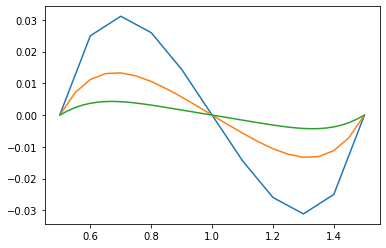

In [115]:
Dom, g, u_naut, u_naut_t, qmax, t_init, t_final,v_a,v_b, v2_a,v2_b, v4_a,v4_b, v6_a,v6_b, exact = Problem3()

test_num = 3
err1=np.zeros(test_num)
err2=np.zeros(test_num)

# Scheme: 1, 2 or 3
k = 3

# CFL number from 0.5 to 2 is used.
CFL = 0.5

# Beta parameter for stability (depends on k)
beta = 0.8

# To test the accuracy of the scheme
for n in range(test_num):

    # Number of grid points
    N = 10*2**(n)

    # Set dx
    dx = (Dom[1]-Dom[0])/N

    # Generate the grid points with the ends included
    x = np.linspace(Dom[0], Dom[1], N+1, endpoint=True)

    start_time = time.time()

    # Set the IC
    u1 = u_naut(x)
    u2 = u_naut_t(x)

    # Intialize t
    t = t_init

    # Stepping routine
    while t < t_final:
        dt = set_dt_AD_1D(t,t_final,CFL,dx,0,qmax)

        if (k==1):
            rhs2 = MOLT_1xx(x,g(u1),dx,dt,CFL,qmax,beta,v_a,v_b,v2_a,v2_b)
            u1, u2 = RK1_v(u1, u2, dt, rhs2)

        elif (k==2):
            u01 = u1
            u02 = u2
            # io = 0
            rhs2 = MOLT_AD_2xx(x,g(u1), u1, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t),v2_b(t),v4_a(t),v4_b(t))
            u1 = u01 + dt*u02
            u2 = u02 + dt*rhs2
            
            # io = 1
            rhs2 = MOLT_AD_2xx(x,g(u1), u1, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+dt),v2_b(t+dt),v4_a(t+dt),v4_b(t+dt))
            u1 = 0.5*u01 + 0.5*(u1 + dt*u2)
            u2 = 0.5*u02 + 0.5*(u2 + dt*rhs2)

        elif (k==3):
            u01 = u1
            u02 = u2
        
            # io = 0
            rhs1 = MOLT_AD_3xx(x,g(u1), u1, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t),v2_b(t),v4_a(t),v4_b(t),v6_a(t),v6_b(t))
            u1,u2 = RK3_v(0, u01,u02, u1, u2, dt, rhs1)
            # io = 1
            rhs1 = MOLT_AD_3xx(x,g(u1), u1, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+dt),v2_b(t+dt),v4_a(t+dt),v4_b(t+dt),v6_a(t+dt),v6_b(t+dt))
            u1,u2 = RK3_v(1, u01,u02, u1, u2, dt, rhs1)
            # io = 2
            rhs1 = MOLT_AD_3xx(x,g(u1), u1, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+0.5*dt),v2_b(t+0.5*dt),v4_a(t+0.5*dt),v4_b(t+0.5*dt),v6_a(t+0.5*dt),v6_b(t+0.5*dt))
            u1,u2 = RK3_v(2, u01,u02, u1, u2, dt, rhs1)

        t += dt

    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )

    # Calculate the error
    u = u1
    exact1 = exact(x,t_final)
#     err1[n]=max(np.abs(exact1-u))
    aa = exact1 - u
    plt.plot(x,aa)
    

# Print the error and the order of the accuracy
# ord1=(np.log(err1[1:None]/err1[0:-1]))/(np.log(1/2))
# print("<Error> & <Order>")
# print("{:.2e}".format(err1[0]), '&   --')
# for n in range(test_num-1):
#     print("{:.2e}".format(err1[n+1]),'&', "{:.3f}".format(ord1[n]))

Total time (s): 0.06913328170776367
Total time (s): 0.15645956993103027
Total time (s): 0.44409918785095215


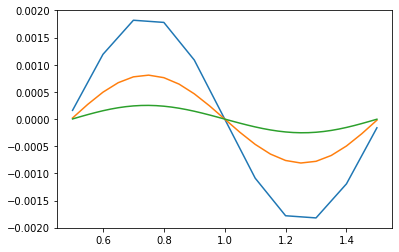

In [117]:
Dom, g, u_naut, u_naut_t, qmax, t_init, t_final,v_a,v_b, v2_a,v2_b, v4_a,v4_b, v6_a,v6_b, exact = Problem3()

test_num = 3
err1=np.zeros(test_num)
err2=np.zeros(test_num)

# Scheme: 1, 2 or 3
k = 3

# CFL number from 0.5 to 2 is used.
CFL = 0.5

# Beta parameter for stability (depends on k)
beta = 0.8

# To test the accuracy of the scheme
for n in range(test_num):

    # Number of grid points
    N = 10*2**(n)

    # Set dx
    dx = (Dom[1]-Dom[0])/N

    # Generate the grid points with the ends included
    x = np.linspace(Dom[0], Dom[1], N+1, endpoint=True)

    start_time = time.time()

    # Set the IC
    u1 = u_naut(x)
    u2 = u_naut_t(x)

    # Intialize t
    t = t_init

    # Stepping routine
    while t < t_final:
        dt = set_dt_AD_1D(t,t_final,CFL,dx,0,qmax)

        if (k==1):
            rhs2 = MOLT_1xx(x,g(u1),dx,dt,CFL,qmax,beta,v_a,v_b,v2_a,v2_b)
            u1, u2 = RK1_v(u1, u2, dt, rhs2)

        elif (k==2):
            u01 = u1
            u02 = u2
            # io = 0
            rhs2 = MOLT_AD_2xx(x,g(u1), u1, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t),v2_b(t),v4_a(t),v4_b(t))
            u1 = u01 + dt*u02
            u2 = u02 + dt*rhs2
            
            # io = 1
            rhs2 = MOLT_AD_2xx(x,g(u1), u1, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+dt),v2_b(t+dt),v4_a(t+dt),v4_b(t+dt))
            u1 = 0.5*u01 + 0.5*(u1 + dt*u2)
            u2 = 0.5*u02 + 0.5*(u2 + dt*rhs2)

        elif (k==3):
            u01 = u1
            u02 = u2
        
            # io = 0
            rhs1 = MOLT_AD_3xx(x,g(u1), u1, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t),v2_b(t),v4_a(t),v4_b(t),v6_a(t),v6_b(t))
            u1,u2 = RK3_v(0, u01,u02, u1, u2, dt, rhs1)
            # io = 1
            rhs1 = MOLT_AD_3xx(x,g(u1), u1, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+dt),v2_b(t+dt),v4_a(t+dt),v4_b(t+dt),v6_a(t+dt),v6_b(t+dt))
            u1,u2 = RK3_v(1, u01,u02, u1, u2, dt, rhs1)
            # io = 2
            rhs1 = MOLT_AD_3xx(x,g(u1), u1, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+0.5*dt),v2_b(t+0.5*dt),v4_a(t+0.5*dt),v4_b(t+0.5*dt),v6_a(t+0.5*dt),v6_b(t+0.5*dt))
            u1,u2 = RK3_v(2, u01,u02, u1, u2, dt, rhs1)

        t += dt

    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )

    # Calculate the error
    u = u1
    exact1 = exact(x,t_final)
#     err1[n]=max(np.abs(exact1-u))
    aa = exact1 - u
    plt.plot(x,aa)
    

# Print the error and the order of the accuracy
# ord1=(np.log(err1[1:None]/err1[0:-1]))/(np.log(1/2))
# print("<Error> & <Order>")
# print("{:.2e}".format(err1[0]), '&   --')
# for n in range(test_num-1):
#     print("{:.2e}".format(err1[n+1]),'&', "{:.3f}".format(ord1[n]))

Burger's equation

### Example 3

We test the accuracy of the scheme for the one-dimensional linear advection-diffusion problem

\begin{align}
\left\{\begin{array}{ll}
u_{t}+c\,u_{x}=q\,u_{xx}, & -1 \leq x\leq 1,\\
u(x,0)=(\sin(\pi x) + x)e^{0.5x},
\end{array}
\right.
\end{align}

with the dirichilet boundary condition $u(-1,t) = - e^{-\frac{1}{2}-\frac{1}{4}t}$ and $u(1,t) = e^{\frac{1}{2}-\frac{1}{4}t}$.
Here, $c$ and $q\geq0$ are given constants.

Let $c = q = 1$. This problem has the exact solution
$u^{e}(x,t)=e^{-\frac{1}{4}t - \pi^2 t +\frac{1}{2}x}\sin(\pi x) + xe^{\frac{1}{2}x-\frac{1}{4}t}.$


We test the accuracy of the scheme for the one-dimensional linear advection-diffusion problem

\begin{align}
\left\{\begin{array}{ll}
u_{t}+c\,u_{x}=q\,u_{xx}, & 0\leq x\leq 1,\\
u(x,0)=\sin(\pi x)e^{0.5x},
\end{array}
\right.
\end{align}

with the dirichilet boundary condition $u(0,t) = 0$ and $u(1,t) = 0$.
Here, $c$ and $q\geq0$ are given constants.

Let $c = q = 1$. This problem has the exact solution
$u^{e}(x,t)=e^{-\frac{1}{4}t - \pi^2 t +\frac{1}{2}x}\sin(\pi x).$

In [27]:
def Problem3():
    '''
    Example1. Accuracy test for the 1D linear advection-diffusion problem
    u_t + c u_x = q u_xx
    '''
    Dom = [-1/2, 1/2]

    c = 1
    q = 1

    def f(u):
        fu = c*u
        return fu

    def g(u):
        gu = q*u
        return gu

    def u_naut(x):
        u_naut = np.sin(np.pi*x)*np.exp(1./2*x)
        return u_naut

    # Compute maximum speed for the IC
    cmax = c
    qmax = q

    t_init = 0
    t_final = 0.5

    #boundary
    def v_a(t):
        v_a = -np.exp(-1./4-1./4*t-np.pi**2*t)
        return v_a

    # v_b = 1.0
    def v_b(t):
        v_b = np.exp(1./4-1./4*t-np.pi**2*t)
        return v_b

    def v1_a(t):
        v1_a = -1/2*np.exp(-1./4-1./4*t-np.pi**2*t)
        return v1_a

    def v1_b(t):
        v1_b = 1./2*np.exp(1./4-1./4*t-np.pi**2*t)
        return v1_b

    def v2_a(t):
        v2_a = (np.pi**2 - 1/4)*np.exp(-1./4-1./4*t-np.pi**2*t)
        return v2_a

    def v2_b(t):
        v2_b = -(np.pi**2 - 1/4)*np.exp(1./4-1./4*t-np.pi**2*t)
        return v2_b

    def v3_a(t):
        v3_a = (3/2*np.pi**2 - 1/8)*np.exp(-1./4-1./4*t-np.pi**2*t)
        return v3_a

    def v3_b(t):
        v3_b = (-3/2*np.pi**2 + 1/8)*np.exp(1./4-1./4*t-np.pi**2*t)
        return v3_b

    def v4_a(t):
        v4_a = (3/2*np.pi**2 - 1/16 - np.pi**4)*np.exp(-1./4-1./4*t-np.pi**2*t)
        return v4_a

    def v4_b(t):
        v4_b = (-3/2*np.pi**2 + 1/16 + np.pi**4)*np.exp(1./4-1./4*t-np.pi**2*t)
        return v4_b

    def v5_a(t):
        v5_a = (5/4*np.pi**2 - 1/32 -5/2*np.pi**4)*np.exp(-1./4-1./4*t-np.pi**2*t)
        return v5_a

    def v5_b(t):
        v5_b = -(5/4*np.pi**2 - 1/32 -5/2*np.pi**4)*np.exp(1./4-1./4*t-np.pi**2*t)
        return v5_b

    def v6_a(t):
        v6_a = -(1/64 - 15/16*np.pi**2  + 15/4*np.pi**4 - np.pi**6)*np.exp(-1./4-1./4*t-np.pi**2*t)
        return v6_a

    def v6_b(t):
        v6_b = (1/64 - 15/16*np.pi**2  + 15/4*np.pi**4 - np.pi**6)*np.exp(1./4-1./4*t-np.pi**2*t)
        return v6_b

    def bdy_dir(v,bn):
    # Here, bn is always 2
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)

        v2[0   ] = 15*v[0]- 40*v[1] + 45*v[2] -24*v[3] + 5*v[4]
        v2[bn-1] =  5*v[0]- 10*v[1] + 10*v[2] - 5*v[3] +    v[4]
        v2[bn:len_v+bn] = v
        v2[len_v+  bn  ] =  5*v[-1] - 10*v[-2] + 10*v[-3] -  5*v[-4] +   v[-5]
        v2[len_v+2*bn-1] = 15*v[-1] - 40*v[-2] + 45*v[-3] - 24*v[-4] + 5*v[-5]

        return v2


    def exact(x,t):
        u = np.exp(-1./4*t - np.pi**2*t +1./2*x) * np.sin(np.pi*x)

        return u

    return Dom, f, g, u_naut, cmax, qmax, t_init, t_final, exact, bdy_dir,v1_a,v1_b,v2_a, v2_b, v3_a, v3_b, v4_a, v4_b, v6_a, v6_b

In [28]:
Dom,f, g, u_naut, cmax, qmax, t_init, t_final, exact, bdy_dir,v1_a,v1_b,v2_a, v2_b, v3_a, v3_b, v4_a, v4_b, v6_a, v6_b = Problem3()

test_num = 3
err1=np.zeros(test_num)
err2=np.zeros(test_num)

# Scheme: 1, 2 or 3
k = 1

# CFL number from 0.5 to 2 is used.
CFL = 0.5

# Beta parameter for stability (depends on k)
beta = 1

# To test the accuracy of the scheme
for n in range(test_num):

    # Number of grid points
    N = 20*2**(n)

    # Set dx
    dx = (Dom[1]-Dom[0])/N

    # Generate the grid points with the ends included
    x = np.linspace(Dom[0], Dom[1], N+1, endpoint=True)

    start_time = time.time()

    # Set the IC
    u = u_naut(x)

    # Intialize t
    t = t_init

    # Stepping routine
    while t < t_final:
        dt = set_dt_AD_1D(t,t_final,CFL,dx,cmax,qmax)

        if (k==1):
            u0 = u
            for io in range(0,k):
                rhs1 = MOLT_AD_1xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t),v2_b(t))
                rhs2 = MOLT_AD_1x(x,f(u), u, cmax, bdy_dir, dx,dt,CFL,beta,v1_a(t),v1_b(t))

                u = RK1(io, u0, u, dt, rhs1+rhs2)

        elif (k==2):
            u0 = u
            # io = 0
            rhs1 = MOLT_AD_2xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t),v2_b(t),v4_a(t),v4_b(t))
            rhs2 = MOLT_AD_2x(x,f(u), u, cmax, bdy_dir, dx,dt,CFL,beta,v1_a(t),v1_b(t),v2_a(t),v2_b(t))

            u = u0 + dt*(rhs1+rhs2)
            # io = 1
            rhs1 = MOLT_AD_2xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+dt),v2_b(t+dt),v4_a(t+dt),v4_b(t+dt))
            rhs2 = MOLT_AD_2x(x,f(u), u, cmax, bdy_dir, dx,dt,CFL,beta,v1_a(t+dt),v1_b(t+dt),v2_a(t+dt),v2_b(t+dt))
            u = 0.5*u0 + 0.5*(u + dt*(rhs1+rhs2))

        elif (k==3):
            u0 = u
            # io = 0
            rhs1 = MOLT_AD_3xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t),v2_b(t),v4_a(t),v4_b(t),v6_a(t),v6_b(t))
            rhs2 = MOLT_AD_3x(x,f(u), u, cmax, bdy_dir, dx,dt,CFL,beta,v1_a(t),v1_b(t),v2_a(t),v2_b(t),v3_a(t),v3_b(t))
            u = u0 + dt*(rhs1+rhs2)

            # io = 1
            rhs1 = MOLT_AD_3xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+dt),v2_b(t+dt),v4_a(t+dt),v4_b(t+dt),v6_a(t+dt),v6_b(t+dt))
            rhs2 = MOLT_AD_3x(x,f(u), u, cmax, bdy_dir, dx,dt,CFL,beta,v1_a(t+dt),v1_b(t+dt),v2_a(t+dt),v2_b(t+dt),v3_a(t+dt),v3_b(t+dt))
            u = 3/4*u0 + 1/4*(u + dt*(rhs1+rhs2))

            # io = 2
            rhs1 = MOLT_AD_3xx(x,g(u), u, qmax, bdy_dir, dx,dt,CFL,beta,v2_a(t+0.5*dt),v2_b(t+0.5*dt),v4_a(t+0.5*dt),v4_b(t+0.5*dt),v6_a(t+0.5*dt),v6_b(t+0.5*dt))
            rhs2 = MOLT_AD_3x(x,f(u), u, cmax, bdy_dir, dx,dt,CFL,beta,v1_a(t+0.5*dt),v1_b(t+0.5*dt),v2_a(t+0.5*dt),v2_b(t+0.5*dt),v3_a(t+0.5*dt),v3_b(t+0.5*dt))
            u = 1/3*u0 + 2/3*(u + dt*(rhs1+rhs2))

        t += dt

    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )

    # Calculate the error
    exact1 = exact(x,t_final)
    err1[n]=max(np.abs(exact1-u))
    err2[n] = sum(np.abs(exact1-u))*dx

# Print the error and the order of the accuracy
ord1=(np.log(err1[1:None]/err1[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err1[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err1[n+1]),'&', "{:.3f}".format(ord1[n]))

ord2=(np.log(err2[1:None]/err2[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err2[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err2[n+1]),'&', "{:.3f}".format(ord2[n]))

NameError: name 'get_boundary__dir_x' is not defined